In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/fixed-point-quadrotor/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems

In [4]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end

qtorp (generic function with 1 method)

In [5]:
#Quadrotor parameters
m = 0.5
ℓ = 0.1750
J = Diagonal([0.0023, 0.0023, 0.004])
g = 9.81
kt=1.0
km=0.0245

h = 0.05 #20 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [6]:
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [7]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [8]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [9]:
#Initial Conditions
uhover = (m*g/4)*ones(4)
r0 = [0.0; 0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [10]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);

In [11]:
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [12]:
# Cost weights
Q = Array(I(Nx̃));
R = Array(.1*I(Nu));

In [13]:
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

4×12 Matrix{Float64}:
 -0.114603      9.48379e-15  1.1308  -7.84272e-13  …  -0.147816      0.681679
  4.79986e-14  -0.114603     1.1308   1.39421         -1.10156e-15  -0.681679
  0.114603      1.38534e-14  1.1308  -9.41369e-13      0.147816      0.681679
  5.23665e-15   0.114603     1.1308  -1.39421         -1.00949e-15  -0.681679

In [14]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    u = uhover - K*Δx̃
end

controller (generic function with 1 method)

In [121]:
#Simulation
uhist = zeros(Nu,Nt)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq(0.1*randn(3)); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end

In [122]:
using PyPlot

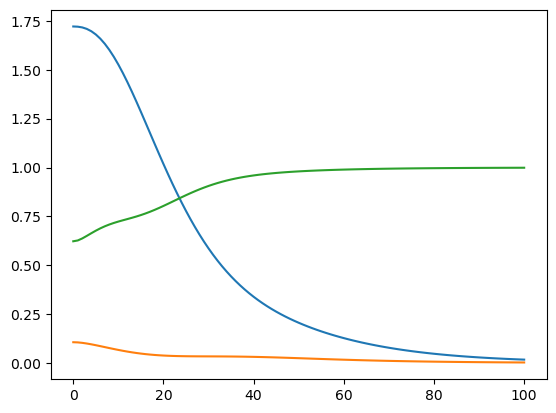

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1952f16c0>

In [123]:
plot(xhist[1,:])
plot(xhist[2,:])
plot(xhist[3,:])

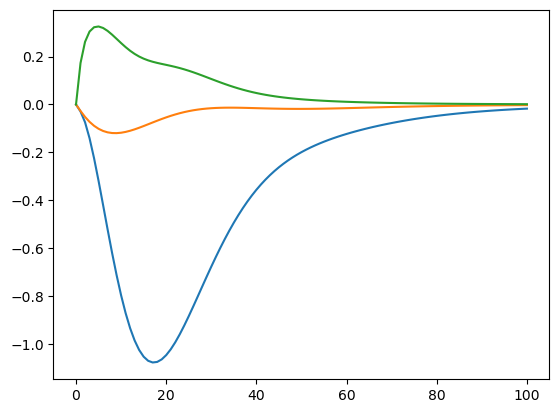

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1953521a0>

In [124]:
plot(xhist[8,:])
plot(xhist[9,:])
plot(xhist[10,:])

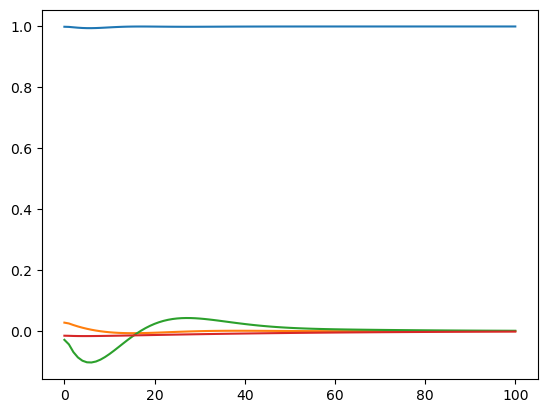

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1953b6890>

In [125]:
plot(xhist[4,:])
plot(xhist[5,:])
plot(xhist[6,:])
plot(xhist[7,:])

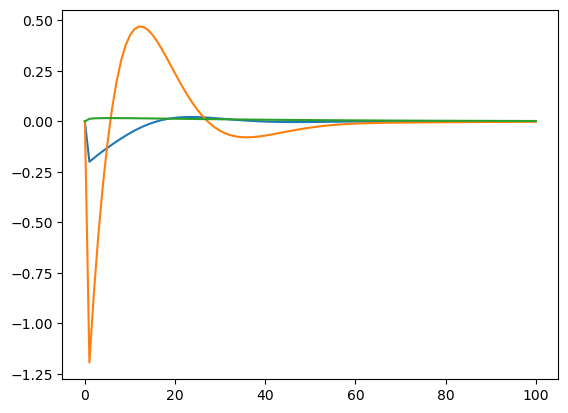

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x19542a710>

In [126]:
plot(xhist[11,:])
plot(xhist[12,:])
plot(xhist[13,:])

In [127]:
#Fixed-Point Conversion

r_max = 100.0
q_max = 10.0
ϕ_max = 30.0
v_max = 100.0
ω_max = 200.0
u_max = 0.5*m*g

fp_max = 2147483647.0

J_xfp = Diagonal([ones(3)*(r_max/fp_max); ones(3)*(ϕ_max/fp_max); ones(3)*(v_max/fp_max); ones(3)*(ω_max/fp_max)])
J_ufp = Diagonal(ones(4)*(fp_max/u_max))

function state_float_to_fixed(x)
    x_fixed = zeros(Int32, 13)
    x_fixed[1:3] .= convert(Vector{Int32},round.(x[1:3].*(fp_max/r_max)))
    x_fixed[4:7] .= convert(Vector{Int32},round.(x[4:7].*(fp_max/q_max)))
    x_fixed[8:10] .= convert(Vector{Int32},round.(x[8:10].*(fp_max/v_max)))
    x_fixed[11:13] .= convert(Vector{Int32},round.(x[11:13].*(fp_max/ω_max)))
    
    return x_fixed
end

function Δstate_float_to_fixed(x)
    x_fixed = zeros(Int32, 12)
    x_fixed[1:3] .= convert(Vector{Int32},round.(x[1:3].*(fp_max/r_max)))
    x_fixed[4:6] .= convert(Vector{Int32},round.(x[4:6].*(fp_max/ϕ_max)))
    x_fixed[7:9] .= convert(Vector{Int32},round.(x[7:9].*(fp_max/v_max)))
    x_fixed[10:12] .= convert(Vector{Int32},round.(x[10:12].*(fp_max/ω_max)))
    
    return x_fixed
end

function state_fixed_to_float(x)
    x_float = zeros(13)
    x_float[1:3] .= convert(Vector{Float64},x[1:3]).*(r_max/fp_max)
    x_float[4:7] .= convert(Vector{Float64},x[4:7]).*(q_max/fp_max)
    x_float[8:10] .= convert(Vector{Float64},x[8:10]).*(v_max/fp_max)
    x_float[11:13] .= convert(Vector{Float64},x[11:13]).*(ω_max/fp_max)
    
    return x_float
end

function Δstate_fixed_to_float(x)
    x_float = zeros(12)
    x_float[1:3] .= convert(Vector{Float64},x[1:3]).*(r_max/fp_max)
    x_float[4:6] .= convert(Vector{Float64},x[4:6]).*(ϕ_max/fp_max)
    x_float[7:9] .= convert(Vector{Float64},x[7:9]).*(v_max/fp_max)
    x_float[10:12] .= convert(Vector{Float64},x[10:12]).*(ω_max/fp_max)
    
    return x_float
end

function controls_float_to_fixed(u)
    u_fixed = zeros(Int32, 4)
    u_fixed[1:4] .= convert(Vector{Int32},round.((u[1:4]).*(fp_max/u_max)))
    
    return u_fixed
end

function controls_fixed_to_float(u)
    u_float = zeros(4)
    u_float[1:4] .= convert(Vector{Float64}, u).*(u_max/fp_max)
    
    return u_float
end

controls_fixed_to_float (generic function with 1 method)

In [128]:
#Feedback controller in fixed-point

K_fixed = round.(J_ufp*K*J_xfp)
uhover_fixed = controls_float_to_fixed(uhover)

Δx0 = zeros(12);
Δx0_fixed = Δstate_float_to_fixed(Δx0)

function controller_fixed(x)
    
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    Δx̃_fixed = Δstate_float_to_fixed(Δx̃)
    
    u_fixed = uhover_fixed - K_fixed*Δx̃_fixed
    
    return controls_fixed_to_float(u_fixed)
end

controller_fixed (generic function with 1 method)

In [129]:
uhover_fixed

4-element Vector{Int32}:
 1073741824
 1073741824
 1073741824
 1073741824

In [130]:
K_fixed

4×12 Matrix{Float64}:
 -5.0   0.0  46.0   -0.0  -17.0   8.0  -7.0   0.0  51.0   -0.0  -12.0   56.0
  0.0  -5.0  46.0   17.0   -0.0  -8.0   0.0  -7.0  51.0   12.0   -0.0  -56.0
  5.0   0.0  46.0   -0.0   17.0   8.0   7.0   0.0  51.0   -0.0   12.0   56.0
  0.0   5.0  46.0  -17.0   -0.0  -8.0   0.0   7.0  51.0  -12.0   -0.0  -56.0

In [131]:
#Simulation
uhist = zeros(Nu,Nt)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq(0.1*randn(3)); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller_fixed(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end

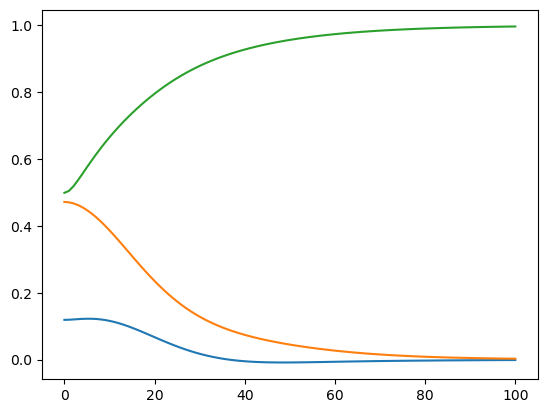

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x19546df90>

In [132]:
plot(xhist[1,:])
plot(xhist[2,:])
plot(xhist[3,:])

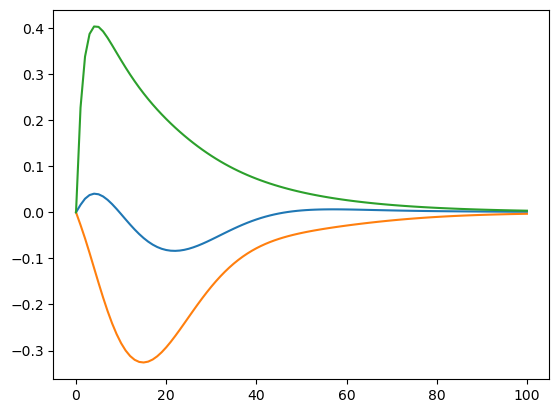

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1954f5db0>

In [133]:
plot(xhist[8,:])
plot(xhist[9,:])
plot(xhist[10,:])

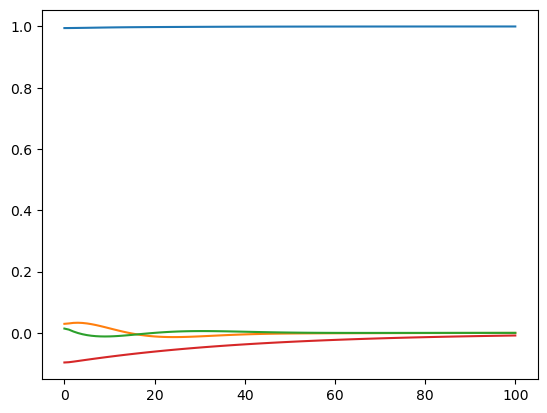

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x195566a40>

In [134]:
plot(xhist[4,:])
plot(xhist[5,:])
plot(xhist[6,:])
plot(xhist[7,:])

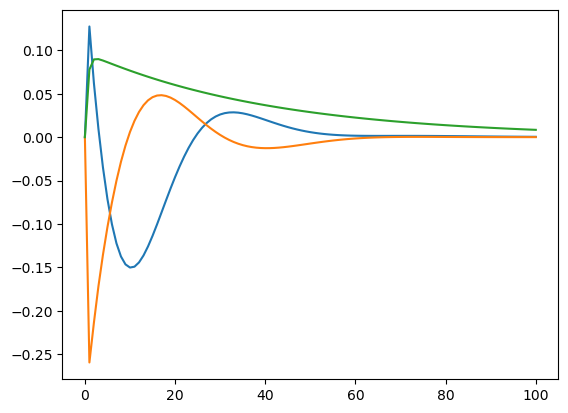

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1955d28c0>

In [135]:
plot(xhist[11,:])
plot(xhist[12,:])
plot(xhist[13,:])